In [34]:
from importlib import reload
import flymovie as fm
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from importlib import reload
import umap
import scipy.ndimage as ndi
import skimage as ski
import matplotlib.image as mpimg
import tempfile
import shutil
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def make_df(filenames):
    """Make a dataframe of parameters from collection of list of simulation
    filenames."""
    p = []
    for f in filenames:
        p.append(f.split('_')[1:-1])

    p = np.array(p)
    p = p.astype(float) 
    df = pd.DataFrame(p, columns=['ntotal', 'HLB diam','HLB nmols', 'n clusters', 'Cluster diam mean', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd','Noise sigma'])
    return df[['ntotal', 'HLB diam','HLB nmols', 'n clusters', 'Cluster diam mean', 'Cluster diam sd','Cluster nmols mean','Cluster nmols sd','Noise sigma']]

def embeddings_match_names(em, names, pattern):
    """Match names to a pattern, select corresponding fows of embedding."""
    if len(names) != em.shape[0]:
        raise ValueError('Sizes of embedding and names object do not match.')

    match_rows = pd.Series(names).str.contains(pattern).to_numpy()
    return em[match_rows], np.array(names)[match_rows]

def dist_to_center(ref_arr, arr):
    """Get the euclidean distance between each row of arr to center (mean) of ref_arr."""
    center = ref_arr.mean(axis=0)
    sqdist = np.sum((arr - center) ** 2, axis=1)
    return np.sqrt(sqdist)


def extract_names_distcutoff(em_real, names_real, em_sims, names_sims, cutoff_lower, cutoff_upper, savestem=None, pattern=''):
    """Extract the parameters of simulations that embed within a cutoff
    distance of the center of a reference set."""
    em_ref, names_ref = embeddings_match_names(em_real, names_real, pattern)
    dists = dist_to_center(em_ref, em_sims)
    names = np.array(names_sims)[(dists <= cutoff_upper) & (dists > cutoff_lower)]
    if savestem is not None:
        np.savetxt(savestem + '_real.txt', names_ref, fmt='%s')
        np.savetxt(savestem + '_sims.txt', names, fmt='%s')
    return names_ref, names

In [28]:
real_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl'
zld_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl'
rpb1_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-rpb1-nc13-library_sJQraOLX__20220619-plussims-20220616-realreal.pkl'

savefile = ''
pattern = 'rpb1.*nc13-3_|rpb1.*nc13-4_|rpb1.*nc13-5_|rpb1.*nc13-6_'
em_real, names_real = fm.load_pickle(real_embedding_pkl)
em_sim, names_sim = fm.load_pickle(rpb1_sims_embedding_pkl)

n = extract_names_distcutoff(em_real, names_real, em_sim, names_sim, 0, 0.3, savestem='/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images/test_0_03', pattern=pattern)

In [35]:
def vis(reals, sims, zmax=False):
    def load_folder(folder):
        l = []
        for f in os.listdir(folder):
            if (f[0] == '.') or (f[-3:] != 'pkl'):
                continue
            im = fm.load_pickle(os.path.join(folder, f))
            l.append(im)
        return np.array(l)
    
    ims_real = load_folder(reals)
    ims_sims = load_folder(sims)
    fm.viewer(ims_real, zmax=zmax)
    fm.viewer(ims_sims, zmax=zmax)
    
    

In [45]:
def vis2(reals, sims, nsample):
    def load_folder(folder):
        l = []
        fnames = []
        for f in os.listdir(folder):
            if (f[0] == '.') or (f[-3:] != 'pkl'):
                continue
            im = fm.load_pickle(os.path.join(folder, f))
            l.append(im)
            fnames.append(f)
        return np.array(l), fnames
    
    def plot(ims, fig, vstart, nrows):
        print(ims.shape)
        for im in ims:
            min_, max_ = np.min(im), np.max(im) * 0.9
            ax = fig.add_axes((0,vstart,0.15,0.15))
            ax.imshow(im.max(axis=0), vmin=min_, vmax=max_, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.18,vstart,0.15,0.15))
            ax.imshow(im[8], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.34,vstart,0.15,0.15))
            ax.imshow(im[14], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.50,vstart,0.15,0.15))
            ax.imshow(im[20], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')
            ax = fig.add_axes((0.66,vstart,0.15,0.15))
            ax.imshow(im[26], vmin=min_, vmax=max_*0.7, cmap='cividis')
            ax.axis('off')

            vstart = vstart - (1 / nrows * 0.77)


    ims_real, _ = load_folder(reals)
    real_idx_sampled = np.random.choice(np.arange(0, ims_real.shape[0]), size=np.min([nsample, ims_real.shape[0]]), replace=False)
    ims_real_sampled = ims_real[real_idx_sampled]

    ims_sims, simnames = load_folder(sims)
    sims_idx_sampled = np.random.choice(np.arange(0, ims_sims.shape[0]), size=np.min([nsample, ims_sims.shape[0]]), replace=False)
    ims_sims_sampled = ims_sims[sims_idx_sampled]

    nrows = nsample * 2
    fig = plt.figure(constrained_layout=False, facecolor='1', figsize=(8.48,12 * nrows / 6))
    plot(ims_real_sampled, fig, 0.89, nrows)
    plot(ims_sims_sampled, fig, 0.89 - (1 / nrows * (nsample + 0.25)), nrows)
    fig.savefig('/Users/michaelstadler/Desktop/test.png',dpi=200)



(3, 34, 100, 100)
(3, 34, 100, 100)


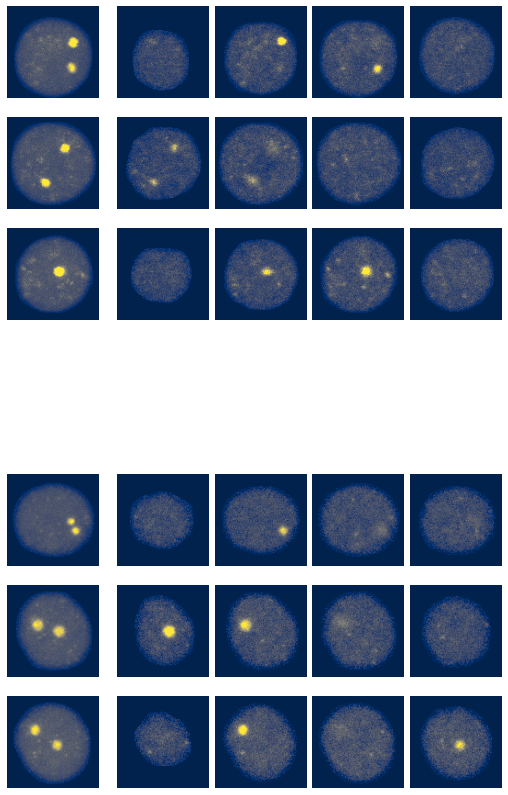

In [26]:
folder1 = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images/test_reals'
folder2 = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/matched_images/test_sims_0_03'

vis2(folder1, folder2, 3)

Take:

embeddings (2)
folder with sims
folder with reals
pattern


(15, 34, 100, 100)
(15, 34, 100, 100)


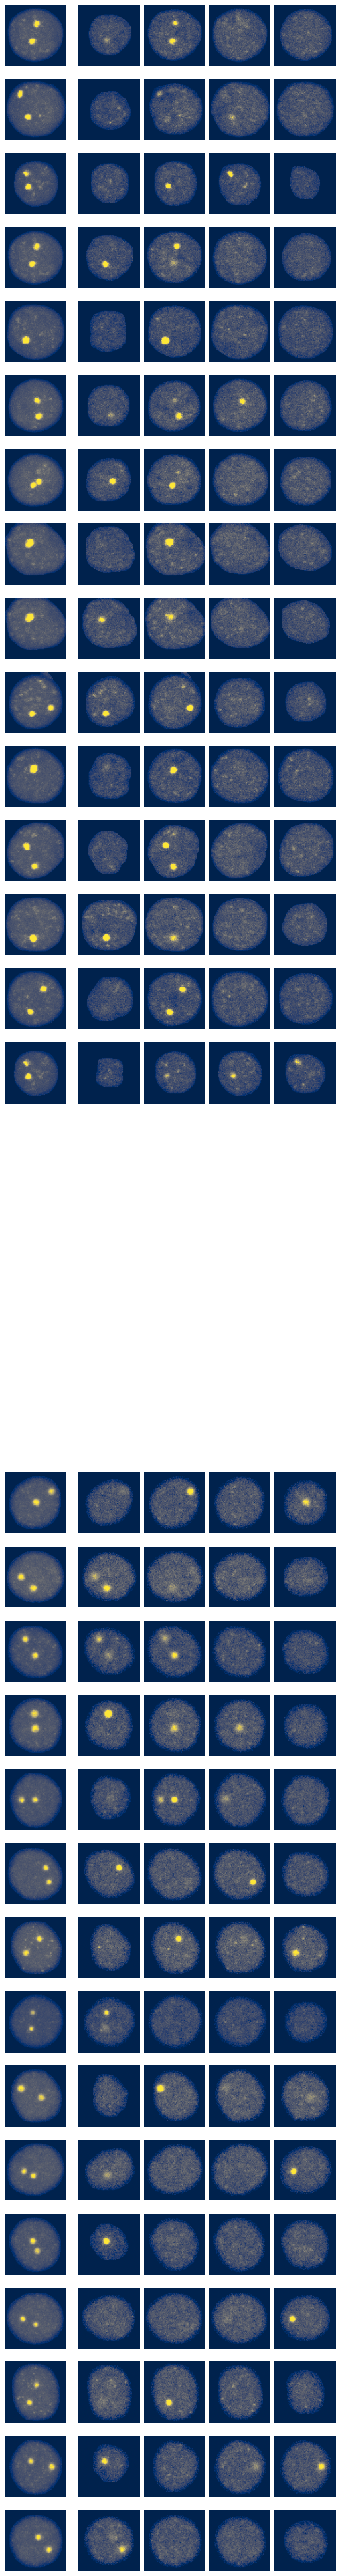

In [46]:
real_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__real-nuclei-set3-matched-20220630__20220619-plussims-20220616-realreal.pkl'
zld_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-zld-nc13-70nm-library_GjGqzRyG__20220619-plussims-20220616-realreal.pkl'
rpb1_sims_embedding_pkl = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/embeddings/embeddings__20220630-rpb1-nc13-library_sJQraOLX__20220619-plussims-20220616-realreal.pkl'

dir_reals = '/Volumes/stadler_5tb/real-nuclei-set3-matched-20220630'
dir_sims = '/Volumes/stadler_5tb/matched_sim_images/rpb1-broad'

savefile = '/Users/michaelstadler/Desktop/test.png'
pattern = 'rpb1.*nc13-4_'
em_real, names_real = fm.load_pickle(real_embedding_pkl)
em_sim, names_sim = fm.load_pickle(rpb1_sims_embedding_pkl)



def func1(real_embedding_pkl, sims_embedding_pkl, dir_reals, dir_sims, pattern, cutoff_lower, cutoff_upper, savefile, nsample):
    def cp_files(fnames, nsample, srcdir, destdir):
        fnames_sampled = np.random.choice(fnames, size=np.min([nsample, len(fnames)]), replace=False)
        for f in fnames_sampled:
            fpath = os.path.join(srcdir, f)
            if os.path.exists(fpath):
                shutil.copy(fpath, destdir)
            

    em_real, names_real = fm.load_pickle(real_embedding_pkl)
    em_sim, names_sim = fm.load_pickle(sims_embedding_pkl)
    names_real, names_sim = extract_names_distcutoff(em_real, names_real, em_sim, names_sim, cutoff_lower, cutoff_upper, pattern=pattern)

    with tempfile.TemporaryDirectory() as tmpdir_reals:
        with tempfile.TemporaryDirectory() as tmpdir_sims:
            cp_files(names_real, nsample, dir_reals, tmpdir_reals)
            cp_files(names_sim, nsample, dir_sims, tmpdir_sims)
            vis2(tmpdir_reals, tmpdir_sims, nsample)
            

    # Make temp folder and stock
func1(real_embedding_pkl, rpb1_sims_embedding_pkl, dir_reals, dir_sims, pattern, 0, 0.25, savefile, 15)

In [47]:
np.exp(-0.014) ** 25

0.7046880897187132